In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

In [2]:
train_df = pd.read_csv('train_for_2012.csv',index_col=0)
train_df.shape

(837913, 43)

In [3]:
test_df = pd.read_csv('test_for_2012.csv',index_col=0)
test_df.shape

(185639, 43)

In [4]:
# df['is_first_occurrence'] = (df['id'] != df['id'].shift()).astype(int)

In [5]:
# modeling_df = df[df['is_first_occurrence']==1].copy()
# print(modeling_df.shape)
# len(modeling_df)/len(df)

In [6]:
train_df['stmt_date'] = pd.to_datetime(train_df['stmt_date'])
train_df['def_date'] = pd.to_datetime(train_df['def_date'], format="%d/%m/%Y")
train_df.sort_values('stmt_date', inplace=True)

In [7]:
### we'll try dropping NA's for now
train_df.sort_values('stmt_date', inplace=True)

## Get preprocessing data ready

In [8]:
from harness_functions import pre_process

In [9]:
with open('quantile_custom_bins.pkl', 'rb') as file:
    custom_bins = pickle.load(file)

In [10]:
preproc_params = {
    'quantile_bins' : {},
    'quantile_values' : {}
}

In [11]:
train_data_proc , preproc_params = pre_process(train_df, 
                                               custom_bins=custom_bins, 
                                               preproc_params = preproc_params,  
                                               quantiles = 50, 
                                               days_until_statement = 150)

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for net_income_growth_quantile


## Train algorithm

In [12]:
### features for first firm
first_features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    # 'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    # 'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    # 'ebitda',
]


In [13]:
### features for recurring firms
rec_features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    # 'ebitda',

]

In [14]:
first_formula = 'default ~ '+' + '.join(first_features)
first_formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + quick_ratio_v2_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile_values'

In [15]:
rec_formula = 'default ~ '+' + '.join(rec_features)
rec_formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + net_income_growth_quantile_values + quick_ratio_v2_quantile_values + sales_growth_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile_values'

In [16]:
class SplitModel():
    def __init__(self, algo):
        self.first_formula = 'default ~ '+' + '.join(first_features)
        self.rec_formula = 'default ~ '+' + '.join(rec_features)

        self.algo = algo
    
    def train(self, data):
        data_idx = data.index
        
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        
        self.first_model = self.algo(self.first_formula, data = first_data)
        self.first_fitted_model = self.first_model.fit()

        self.rec_model = self.algo(self.rec_formula, data = rec_data)
        self.rec_fitted_model = self.rec_model.fit()
        print("models fit")

    def predict(self, data):
        rec_data = data[data['is_first_occurrence']==0]
        first_data = data[data['is_first_occurrence']==1]
        print('rec data length',len(rec_data))
        print('first data length',len(first_data))
        
        rec_preds = self.rec_fitted_model.predict(rec_data)
        rec_preds = rec_preds.reindex(rec_data.index)
        
        first_preds = self.first_fitted_model.predict(first_data)
        first_preds = first_preds.reindex(first_data.index)

        predictions = pd.concat([rec_preds,first_preds]).reindex(data.index)
        
        return predictions

In [17]:
model = SplitModel(algo=smf.logit)

In [18]:
model.train(train_data_proc)

Optimization terminated successfully.
         Current function value: 0.051107
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.064320
         Iterations 10
models fit


In [19]:
train_data_proc.index

Index([     22,      18,      19,      23,      17,      37,      36,      35,
            39,      52,
       ...
       4437666, 4437672, 4437674, 4437671, 4437673, 4437676, 4437705, 4437703,
       4437709, 4437706],
      dtype='int64', name='Unnamed: 0', length=837913)

In [20]:
preds = model.predict(train_data_proc)

rec data length 612920
first data length 224993


### Model results

In [21]:
print(fitted_model.summary())

NameError: name 'fitted_model' is not defined

In [22]:
print(fitted_model.get_margeff().summary())

NameError: name 'fitted_model' is not defined

## Process test data

In [21]:
test_df['stmt_date'] = pd.to_datetime(test_df['stmt_date'])
test_df['def_date'] = pd.to_datetime(test_df['def_date'], format="%d/%m/%Y")
test_df.sort_values('stmt_date', inplace=True)

In [22]:
test_data_proc , preproc_params = pre_process(test_df, 
                                             historical_df=train_data_proc, 
                                             new=False, 
                                             preproc_params = preproc_params,  
                                             quantiles = 50, 
                                             days_until_statement = 150)

asst_tot_quantile
financial_leverage_quantile
profitability_ratio_quantile
net_income_growth_quantile
quick_ratio_v2_quantile
sales_growth_quantile
cash_assets_ratio_quantile
dscr_quantile


In [81]:
concat_df = pd.concat([test_df, train_df]).sort_values(by=['id', 'stmt_date'])


In [82]:

concat_df['is_first_occurrence'] = (concat_df['id'] != concat_df['id'].shift()).astype(int)

In [83]:
concat_df['is_first_occurrence'].loc[[2757816]]

Unnamed: 0
2757816    0
Name: is_first_occurrence, dtype: int64

In [84]:
test_df.join(concat_df[['is_first_occurrence']], how='left')

,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,asst_fixed_fin,...,asst_tot_quantile_values,liab_tot,financial_leverage,financial_leverage_quantile,financial_leverage_quantile_values,profitability_ratio,profitability_ratio_quantile,profitability_ratio_quantile_values,net_income,is_first_occurrence
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
21,520288,2012-12-31,28.0,SRL,14.0,NaT,2012,15195.0,1116938.0,2023.0,...,0.015157,1743535.0,0.930937,10,0.019356,-0.133904,28,0.074964,-250786.0,0
2757816,3617000967,2012-12-31,98.0,SRL,41.0,NaT,2012,713.0,0.0,0.0,...,0.012651,4107667.0,1.041422,38,0.109290,-0.044572,34,0.028249,-175805.0,0
2757825,3617020403,2012-12-31,36.0,SRL,41.0,NaT,2012,0.0,0.0,402580.0,...,0.014322,5694633.0,0.996110,11,0.017668,-0.004833,49,0.011091,-27630.0,0
2757832,3617030873,2012-12-31,87.0,SRL,68.0,NaT,2012,660.0,1281677.0,60500.0,...,0.015933,461317.0,0.288364,3,0.004496,0.045194,57,0.003366,72301.0,0
2757853,3617080167,2012-12-31,23.0,SRU,35.0,NaT,2012,209976.0,3057579.0,40635.0,...,0.011935,2940376.0,0.782006,7,0.009576,0.001224,51,0.010079,4601.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122512,1768810366,2012-12-31,36.0,SRL,55.0,NaT,2012,2529.0,9187406.0,4870.0,...,0.012651,1037049.0,0.110377,2,0.005503,-0.033838,36,0.019502,-317928.0,0
1122564,1768870501,2012-12-31,50.0,SRU,41.0,NaT,2012,0.0,1745066.0,0.0,...,0.013545,1621550.0,0.810803,8,0.012087,0.004010,53,0.006582,8019.0,0
1122600,1768900688,2012-12-31,68.0,SRU,85.0,NaT,2012,103408.0,5190.0,4900.0,...,0.013068,2747373.0,0.968816,11,0.017668,-0.000365,50,0.011304,-1034.0,0


In [23]:
test_data_proc.head()

,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,asst_fixed_fin,...,sales,sales_growth,sales_growth_quantile,sales_growth_quantile_values,cash_assets_ratio,cash_assets_ratio_quantile,cash_assets_ratio_quantile_values,dscr,dscr_quantile,dscr_quantile_values
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
21,520288,2012-12-31,28.0,SRL,14.0,NaT,2012,15195.0,1116938.0,2023.0,...,319790.0,NaN,NaN,0.01,0.003496,18,0.016469,-11.487373,4,0.069459
2757816,3617000967,2012-12-31,98.0,SRL,41.0,NaT,2012,713.0,0.0,0.0,...,1.0,NaN,NaN,0.01,0.001071,12,0.016171,-0.342103,8,0.029538
2757825,3617020403,2012-12-31,36.0,SRL,41.0,NaT,2012,0.0,0.0,402580.0,...,417138.0,NaN,NaN,0.01,0.000069,4,0.015396,0.839333,13,0.010204
2757832,3617030873,2012-12-31,87.0,SRL,68.0,NaT,2012,660.0,1281677.0,60500.0,...,115449.0,NaN,NaN,0.01,0.004307,19,0.018081,6.180548,34,0.004714
2757853,3617080167,2012-12-31,23.0,SRU,35.0,NaT,2012,209976.0,3057579.0,40635.0,...,762290.0,NaN,NaN,0.01,0.079881,41,0.009249,2.684605,24,0.008414


In [24]:
test_predictions = model.predict(test_data_proc)

rec data length 45308
first data length 12418


In [34]:
rec_data = test_data_proc[test_data_proc['is_first_occurrence']==0]
first_data = test_data_proc[test_data_proc['is_first_occurrence']==1]
print('rec data length',len(rec_data))
print('first data length',len(first_data))


rec data length 45308
first data length 12418


In [36]:
rec_preds = model.rec_fitted_model.predict(rec_data)
rec_preds = rec_preds.reindex(rec_data.index)

first_preds = model.first_fitted_model.predict(first_data)
first_preds = first_preds.reindex(first_data.index)

predictions = pd.concat([rec_preds,first_preds]).reindex(test_data_proc.index)

In [55]:
rec_data.shape, model.rec_fitted_model.predict(rec_data[rec_features]).shape

((45308, 71), (45308,))

In [57]:
first_preds.shape, model.first_fitted_model.predict(first_data).shape

((12418,), (12418,))

In [59]:
45308+12418,test_data_proc.shape

(57726, (185639, 71))

In [47]:
pd.concat([rec_preds,first_preds])

Unnamed: 0
21        0.051165
424056    0.015324
424061    0.012339
424069    0.004438
424097    0.005748
            ...   
848741    0.010446
848393    0.009932
848032    0.004288
848037    0.005729
848248    0.009548
Length: 57726, dtype: float64

In [31]:
test_predictions

Unnamed: 0
21         0.051165
2757816         NaN
2757825         NaN
2757832         NaN
2757853         NaN
             ...   
1122512         NaN
1122564         NaN
1122600         NaN
1122640         NaN
4885789         NaN
Length: 185639, dtype: float64

In [25]:
test_results = test_data_proc[['default']].copy()
test_results['predictions'] = test_predictions

In [26]:
test_results.head()

,default,predictions
Unnamed: 0,,
21,0,0.051165
2757816,0,NaN
2757825,0,NaN
2757832,0,NaN
2757853,0,NaN


In [27]:
(test_df['id'].isin(train_df['id'])).sum()

np.int64(172921)

In [28]:
test_data_proc['is_first_occurrence'].sum()

np.float64(12418.0)

In [29]:
test_data_proc

,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,asst_fixed_fin,...,sales,sales_growth,sales_growth_quantile,sales_growth_quantile_values,cash_assets_ratio,cash_assets_ratio_quantile,cash_assets_ratio_quantile_values,dscr,dscr_quantile,dscr_quantile_values
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
21,520288,2012-12-31,28.0,SRL,14.0,NaT,2012,15195.0,1116938.0,2023.0,...,319790.0,NaN,NaN,0.01,0.003496,18,0.016469,-11.487373,4,0.069459
2757816,3617000967,2012-12-31,98.0,SRL,41.0,NaT,2012,713.0,0.0,0.0,...,1.0,NaN,NaN,0.01,0.001071,12,0.016171,-0.342103,8,0.029538
2757825,3617020403,2012-12-31,36.0,SRL,41.0,NaT,2012,0.0,0.0,402580.0,...,417138.0,NaN,NaN,0.01,0.000069,4,0.015396,0.839333,13,0.010204
2757832,3617030873,2012-12-31,87.0,SRL,68.0,NaT,2012,660.0,1281677.0,60500.0,...,115449.0,NaN,NaN,0.01,0.004307,19,0.018081,6.180548,34,0.004714
2757853,3617080167,2012-12-31,23.0,SRU,35.0,NaT,2012,209976.0,3057579.0,40635.0,...,762290.0,NaN,NaN,0.01,0.079881,41,0.009249,2.684605,24,0.008414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122512,1768810366,2012-12-31,36.0,SRL,55.0,NaT,2012,2529.0,9187406.0,4870.0,...,861016.0,NaN,NaN,0.01,0.003733,18,0.016469,4.586362,31,0.005132
1122564,1768870501,2012-12-31,50.0,SRU,41.0,NaT,2012,0.0,1745066.0,0.0,...,246405.0,NaN,NaN,0.01,0.010708,25,0.013546,4.959751,32,0.004475
1122600,1768900688,2012-12-31,68.0,SRU,85.0,NaT,2012,103408.0,5190.0,4900.0,...,3309407.0,NaN,NaN,0.01,0.007530,23,0.015813,11.029252,39,0.004833


In [30]:
metrics.roc_auc_score(y_score=test_results['predictions'], y_true=test_results['default'])

ValueError: Input contains NaN.

ROC AUC 0.8259366425848987


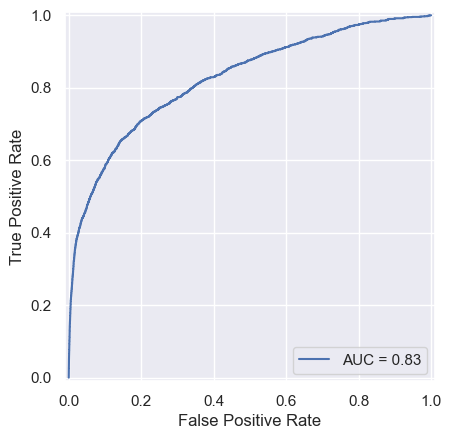

In [190]:
fpr, tpr, thresholds = metrics.roc_curve(test_results['default'], test_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

In [50]:
# train_data_proc.to_csv('train_processed_data_for_2012.csv', index=False)
# test_data_proc.to_csv('test_processed_data_for_2012.csv', index=False)

## saving components for harness

In [58]:
growth_features = [
    'id',
    'stmt_date',
    'net_income',
    'sales'
]

In [59]:
train_data_proc

,Unnamed: 0,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,...,sales,sales_growth,sales_growth_quantile,sales_growth_quantile_values,cash_assets_ratio,cash_assets_ratio_quantile,cash_assets_ratio_quantile_values,dscr,dscr_quantile,dscr_quantile_values
3,22,520288,2007-12-31,28.0,SRL,14.0,NaT,2007,126603.0,1127807.0,...,2041155.0,0.000000,19,0.010524,0.008071,23,0.015813,11.280124,39,0.004833
1,18,520288,2008-12-31,28.0,SRL,14.0,NaT,2008,256438.0,1181416.0,...,967389.0,-0.526058,5,0.031686,0.002570,16,0.017604,0.926243,13,0.010204
2,19,520288,2009-12-31,28.0,SRL,14.0,NaT,2009,194046.0,1152014.0,...,638687.0,-0.339783,7,0.025480,0.005310,21,0.016470,1.918641,20,0.012293
4,23,520288,2010-12-31,28.0,SRL,14.0,NaT,2010,130973.0,1136731.0,...,564622.0,-0.115964,12,0.015813,0.003440,18,0.016469,0.253106,10,0.021958
0,17,520288,2011-12-31,28.0,SRL,14.0,NaT,2011,67537.0,1137566.0,...,538081.0,-0.047007,16,0.009667,0.001070,12,0.016171,0.406302,11,0.017126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776130,4437676,98111220178,2011-12-31,17.0,SRL,70.0,NaT,2011,0.0,54284.0,...,41583.0,0.386100,33,0.010085,0.002758,17,0.016231,-115.380952,2,0.030493
776132,4437705,98120940170,2008-12-31,17.0,SRU,38.0,NaT,2008,6749.0,111056.0,...,2279183.0,0.000000,19,0.010524,0.472416,51,0.012590,3.993937,29,0.005490
776131,4437703,98120940170,2009-12-31,17.0,SRU,38.0,NaT,2009,8640.0,125236.0,...,1931329.0,-0.152622,11,0.016589,0.289645,49,0.006325,-1.864468,6,0.050361
776134,4437709,98120940170,2010-12-31,17.0,SRU,38.0,NaT,2010,16127.0,72130.0,...,2164420.0,0.120689,28,0.007399,0.119598,44,0.008235,0.659516,12,0.013665
